In [1]:
import numpy as np
from firedrake import UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction
from firedrake import SpatialCoordinate, dx, pi, sin, dot, grad, DirichletBC, Constant
from firedrake import assemble, Function, solve
from firedrake import norms

import stat_fem
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from scipy.stats import norm as normal
from scipy.stats import gamma

from firedrake.petsc import PETSc

import os
from pathlib import Path
fig_path = Path.home() / 'Dropbox' / 'phd' / 'projects' / 'stat-fem' / 'meeting-notes' / '2020-04-27-images'

from tqdm import tqdm

In [2]:
class ThetaPriorGamma:
    
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def sample(self):
        return gamma.rvs(self.a, scale=self.b)
    
    def logpdf(self, theta):
        return gamma.logpdf(theta, self.a, scale=self.b)
    
class LogThetaPriorNormal:
    
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale

    def sample(self):
        return np.random.normal(self.loc, self.scale)
    
    def logpdf(self, log_theta):
        return normal.logpdf(log_theta, self.loc, self.scale)
    

def theta_proposal_logpdf(theta_from, theta_to, prop_std):
    return normal.logpdf(theta_to, theta_from, prop_std)

def theta_proposal_sample(theta, prop_std):
    return np.random.normal(theta, prop_std)
# specify the epsilon_f

In [3]:
is_prior_logscale = True

if is_prior_logscale:
    theta_prior = LogThetaPriorNormal(0, 1)
else:
    theta_prior = ThetaPriorGamma(1, 1)

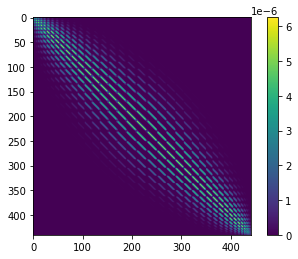

In [39]:
nx = 21

mesh = UnitSquareMesh(nx - 1, nx - 1)
V = FunctionSpace(mesh, "CG", 1)

M = mesh.coordinates.vector().dat.data.shape[0]

u = TrialFunction(V)
v = TestFunction(V)

f = Function(V)
x = SpatialCoordinate(mesh)
# f.interpolate(Constant(10))
f.interpolate(-(8*pi*pi)*sin(x[0]*pi*2)*sin(x[1]*pi*2))
# f.interpolate(10 + 5 * (sin(2 * pi * x[0]) + sin(2 * pi * x[1])))


L = f * v * dx
b = assemble(L)
b_np = b.vector().dat.data

bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]


log_sigma_f = np.log(1)
log_l_f = np.log(0.1)

G = stat_fem.ForcingCovariance(V, log_sigma_f, log_l_f, cutoff=1e-20)
G.assemble()
G_np = G.G.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))

plt.imshow(G_np)
plt.colorbar()

## Monte Carlo estimate

In [5]:
mc_num_samples = 1_000_000
u_samples_mc = np.zeros((mc_num_samples, M))

u_trial = TrialFunction(V)
v = TestFunction(V)

for n in tqdm(range(mc_num_samples)):
    theta_n = theta_prior.sample()
    if is_prior_logscale:
        theta_n = np.exp(theta_n)
    
    a =  (dot(grad(v), Constant(theta_n) * grad(u_trial))) * dx
    A = assemble(a, bcs=bc)
    u_mean = Function(V)
    solve(A, u_mean, b)
    
    u_samples_mc[n, :] = u_mean.vector().dat.data.copy()

100%|██████████| 1000000/1000000 [8:12:14<00:00, 33.86it/s]  


In [ ]:
mc_cum_sum = np.cumsum(u_samples_mc, axis=0)
mc_cum_mean = mc_cum_sum / (1 + np.arange(mc_num_samples))[:, np.newaxis]
mc_cum_mean_norm = np.linalg.norm(mc_cum_mean, axis=1)

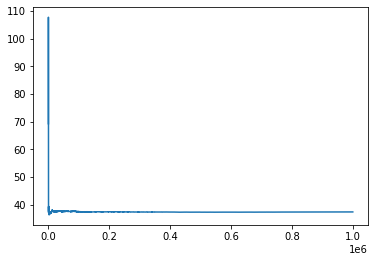

In [54]:
plt.plot(mc_cum_mean_norm[:1_000_000])

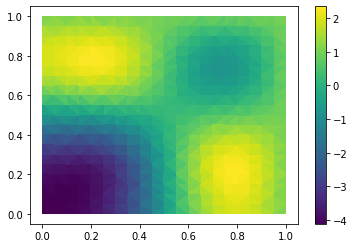

In [7]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              mc_cum_mean[-1])
plt.colorbar()

## MCMC

In [31]:
mcmc_num_samples = 10_000

def log_likelihood(u: np.ndarray, 
                   b: np.ndarray,
                   A: np.ndarray, 
                   G: np.ndarray):
    (_, log_det) = np.linalg.slogdet(A) # A is pos. definite so sign ignored
    result = log_det
    result += np.dot(u, np.dot(A, np.linalg.solve(G, b)))
    result = result -0.5 * np.dot(u, np.dot(A, np.linalg.solve(G, np.dot(A, u))))
    return result

u_samples_mcmc = np.zeros((mcmc_num_samples, M))
theta_samples_mcmc = np.zeros(mcmc_num_samples)

warmup_interval_check = 50
num_samples_warmup = int(0.2 * mcmc_num_samples)

accepted = 0

theta = np.exp(np.random.normal(0, 1e-3))
u = np.zeros(M)

prop_std = 1e-1 # initial value for the std of the proposal

for n in tqdm(range(mcmc_num_samples)):
    # Recalibrate proposal density for ω
    if n < num_samples_warmup and  ((n + 1) % warmup_interval_check == 0):
        ar = float(accepted) / float(warmup_interval_check)
        if ar < 0.4:
            print(f"AR = {ar} - rescaling the proposal density.")
            prop_std -= .1 * prop_std
            prop_std = np.abs(prop_std)
        elif ar > 0.6:
            print(f"AR = {ar} - rescaling the proposal density.")
            prop_std += .1 * prop_std 
        accepted = 0
  
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), theta_constant * grad(u_trial))) * dx, bcs=bc)
    
    u_mean = Function(V)
    solve(A, u_mean, b) # firedrake solve
    
    A_np = A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    A_inv_np = np.linalg.inv(A_np)
    u_cov = A_inv_np @ G_np @ A_inv_np

    # 1. sample from p(u|theta) using a closed form expression
    u = np.random.multivariate_normal(u_mean.vector().dat.data, u_cov)
    
    # 2. sample from p(theta|u) via a Metropolis-step
    theta_star = theta_proposal_sample(theta, prop_std)
    
    if is_prior_logscale or theta_star > 0: # enforce the positivty
        u_trial = TrialFunction(V)
        v = TestFunction(V)
        theta_star_constant = Constant(np.exp(theta_star)) if is_prior_logscale else Constant(theta_star)
        A_star = assemble((dot(grad(v), theta_star_constant * grad(u_trial))) * dx, bcs=bc)
        A_star_np = A_star.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
        A_star_inv_np = np.linalg.inv(A_star_np)

        u_mean_star = Function(V)
        solve(A_star, u_mean_star, b) # firedrake solve
        u_cov_star = A_star_inv_np @ G_np @ A_star_inv_np

        log_p_u_given_theta_star = log_likelihood(u, b_np, A_star_np, G_np)
        log_p_u_given_theta = log_likelihood(u, b_np, A_np, G_np)

        log_ar = log_p_u_given_theta_star + theta_prior.logpdf(theta_star) + theta_proposal_logpdf(theta_star, theta, prop_std)
        log_ar = log_ar - log_p_u_given_theta - theta_prior.logpdf(theta) - theta_proposal_logpdf(theta, theta_star, prop_std)

        if np.exp(log_ar) > np.random.uniform(0, 1):
            accepted += 1
            theta = theta_star

    theta_samples_mcmc[n] = theta
    u_samples_mcmc[n, :] = u

  1%|          | 99/10000 [00:32<48:43,  3.39it/s]  

AR = 0.12 - rescaling the proposal density.


  1%|▏         | 149/10000 [00:48<49:23,  3.32it/s]  

AR = 0.02 - rescaling the proposal density.


  2%|▏         | 199/10000 [01:08<1:07:24,  2.42it/s]

AR = 0.0 - rescaling the proposal density.


  2%|▏         | 249/10000 [01:23<43:56,  3.70it/s]  

AR = 0.0 - rescaling the proposal density.


  3%|▎         | 299/10000 [01:37<44:27,  3.64it/s]

AR = 0.0 - rescaling the proposal density.


  3%|▎         | 349/10000 [01:50<42:50,  3.75it/s]

AR = 0.0 - rescaling the proposal density.


  4%|▍         | 399/10000 [02:04<49:50,  3.21it/s]

AR = 0.0 - rescaling the proposal density.


  4%|▍         | 449/10000 [02:22<43:58,  3.62it/s]  

AR = 0.02 - rescaling the proposal density.


  5%|▍         | 499/10000 [02:33<34:25,  4.60it/s]

AR = 0.0 - rescaling the proposal density.


  5%|▌         | 549/10000 [02:44<33:37,  4.68it/s]

AR = 0.02 - rescaling the proposal density.


  6%|▌         | 599/10000 [02:54<32:34,  4.81it/s]

AR = 0.04 - rescaling the proposal density.


  6%|▋         | 649/10000 [03:05<32:33,  4.79it/s]

AR = 0.02 - rescaling the proposal density.


  7%|▋         | 699/10000 [03:16<32:05,  4.83it/s]

AR = 0.0 - rescaling the proposal density.


  7%|▋         | 749/10000 [03:27<38:25,  4.01it/s]

AR = 0.02 - rescaling the proposal density.


  8%|▊         | 799/10000 [03:37<32:17,  4.75it/s]

AR = 0.0 - rescaling the proposal density.


  8%|▊         | 849/10000 [03:48<32:09,  4.74it/s]

AR = 0.0 - rescaling the proposal density.


  9%|▉         | 899/10000 [03:59<31:23,  4.83it/s]

AR = 0.0 - rescaling the proposal density.


  9%|▉         | 949/10000 [04:10<32:58,  4.57it/s]

AR = 0.02 - rescaling the proposal density.


 10%|▉         | 999/10000 [04:22<32:56,  4.55it/s]

AR = 0.04 - rescaling the proposal density.


 10%|█         | 1049/10000 [04:33<42:16,  3.53it/s]

AR = 0.06 - rescaling the proposal density.


 11%|█         | 1099/10000 [04:50<44:40,  3.32it/s]  

AR = 0.02 - rescaling the proposal density.


 11%|█▏        | 1149/10000 [05:05<44:44,  3.30it/s]

AR = 0.1 - rescaling the proposal density.


 12%|█▏        | 1199/10000 [05:20<41:03,  3.57it/s]

AR = 0.0 - rescaling the proposal density.


 12%|█▏        | 1249/10000 [05:35<42:15,  3.45it/s]

AR = 0.0 - rescaling the proposal density.


 13%|█▎        | 1299/10000 [05:50<41:39,  3.48it/s]

AR = 0.06 - rescaling the proposal density.


 13%|█▎        | 1349/10000 [06:05<38:55,  3.70it/s]

AR = 0.04 - rescaling the proposal density.


 14%|█▍        | 1399/10000 [06:20<41:06,  3.49it/s]

AR = 0.06 - rescaling the proposal density.


 14%|█▍        | 1449/10000 [06:34<38:04,  3.74it/s]

AR = 0.02 - rescaling the proposal density.


 15%|█▍        | 1499/10000 [06:50<43:04,  3.29it/s]

AR = 0.1 - rescaling the proposal density.


 15%|█▌        | 1549/10000 [07:05<40:43,  3.46it/s]

AR = 0.02 - rescaling the proposal density.


 16%|█▌        | 1599/10000 [07:20<39:51,  3.51it/s]

AR = 0.0 - rescaling the proposal density.


 16%|█▋        | 1649/10000 [07:34<38:44,  3.59it/s]

AR = 0.08 - rescaling the proposal density.


 17%|█▋        | 1699/10000 [07:49<46:42,  2.96it/s]

AR = 0.06 - rescaling the proposal density.


 17%|█▋        | 1749/10000 [08:04<42:13,  3.26it/s]

AR = 0.06 - rescaling the proposal density.


 18%|█▊        | 1799/10000 [08:20<39:48,  3.43it/s]

AR = 0.08 - rescaling the proposal density.


 18%|█▊        | 1849/10000 [08:44<35:59,  3.77it/s]  

AR = 0.04 - rescaling the proposal density.


 19%|█▉        | 1899/10000 [08:58<49:03,  2.75it/s]

AR = 0.04 - rescaling the proposal density.


 19%|█▉        | 1949/10000 [09:10<27:25,  4.89it/s]  

AR = 0.04 - rescaling the proposal density.


 20%|█▉        | 1999/10000 [09:21<28:38,  4.66it/s]

AR = 0.14 - rescaling the proposal density.


100%|██████████| 10000/10000 [40:03<00:00,  4.16it/s] 


In [ ]:
mcmc_cum_sum = np.cumsum(u_samples_mcmc[num_samples_warmup:], axis=0)
mcmc_cum_mean = mcmc_cum_sum / (1 + np.arange(mcmc_num_samples - num_samples_warmup))[:, np.newaxis]
mcmc_cum_mean_norm = np.linalg.norm(mcmc_cum_mean, axis=1, ord=2)

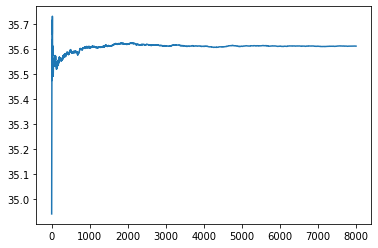

In [60]:
plt.plot(mcmc_cum_mean_norm)

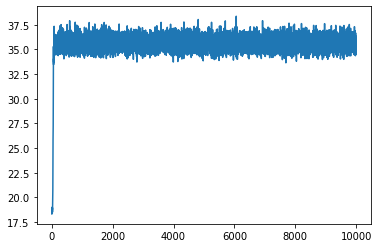

In [33]:
plt.plot(np.linalg.norm(u_samples_mcmc, axis=1, ord=2))

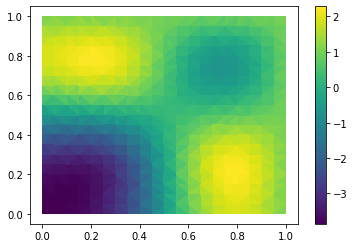

In [34]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              np.mean(u_samples_mcmc[num_samples_warmup:], axis=0))
plt.colorbar()

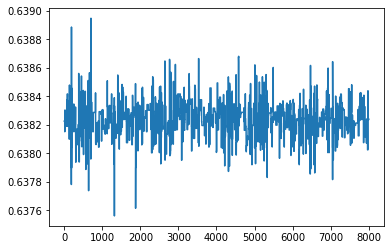

In [35]:
plt.plot(np.exp(theta_samples_mcmc[num_samples_warmup:]) if is_prior_logscale else theta_samples_mcmc[num_samples_warmup:])

## EM

In [26]:
from scipy.optimize import minimize_scalar as minimize

num_samples = 20

def e_step(theta):
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), Constant(theta_constant) * grad(u_trial))) * dx, bcs=bc)
    
    u_mean = Function(V)
    solve(A, u_mean, b) # firedrake solve
    return u_mean.vector().dat.data

def m_step(theta, u_np, G, b_np):
   
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    theta_constant = Constant(np.exp(theta)) if is_prior_logscale else Constant(theta)
    A = assemble((dot(grad(v), theta_constant * grad(u_trial))) * dx, bcs=bc)
    
    A_np = A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    G_np = G.G.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    
    (_, log_det) = np.linalg.slogdet(A_np) # A is pos. definite so sign ignored
    result = log_det
    
    result += np.dot(u_np, np.dot(A_np, np.linalg.solve(G_np, b_np)))
    result = result -0.5 * np.dot(u_np, np.dot(A_np, np.linalg.solve(G_np, np.dot(A_np, u_np))))
    
    result += theta_prior.logpdf(theta)
    return -1 * result

theta = 10

em_u_samples = np.zeros((num_samples, M))
em_theta_samples = np.zeros(num_samples)
             
for n in tqdm(range(num_samples)):
    
    current_u = e_step(theta)
    em_u_samples[n, :] = current_u.copy()
    
    if is_prior_logscale:
        opt_result = minimize(m_step, args=(current_u, G, b_np))  
    else:
        opt_result = minimize(m_step, args=(current_u, G, b_np), bounds=(0, np.inf), method='bounded')
    theta = opt_result.x
    em_theta_samples[n] = theta
    
# print(em_omega_samples)

100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


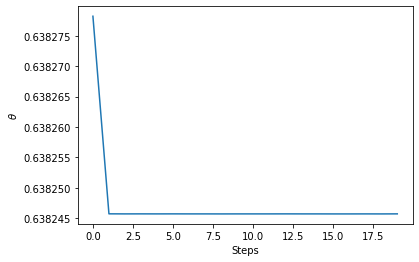

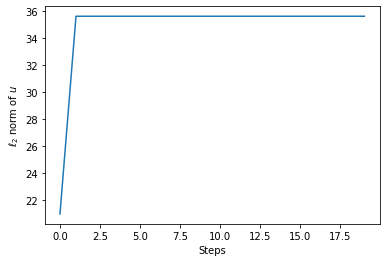

In [27]:
fig, ax = plt.subplots()
ax.plot(np.exp(em_theta_samples) if is_prior_logscale else em_theta_samples)
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\\theta$')
ax.set_xlabel('Steps')
plt.show()

fig, ax = plt.subplots()
ax.plot(np.linalg.norm(em_u_samples, axis=1, ord=2))
ax.ticklabel_format(useOffset=False)
ax.set_ylabel('$\ell_2$ norm of $u$')
ax.set_xlabel('Steps')
plt.show()

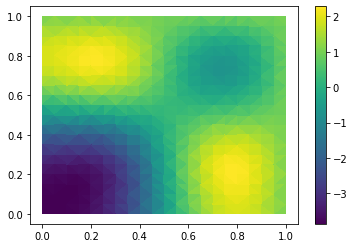

In [36]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              em_u_samples[-1])
plt.colorbar()

# Differences

## MCMC vs MC

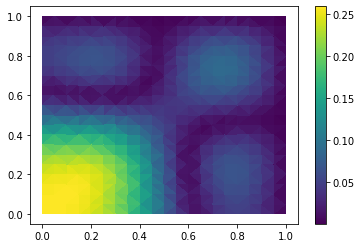

In [61]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              np.abs(mc_cum_mean[-1] - mcmc_cum_mean[-1]))
plt.colorbar()

## EM vs MCMC

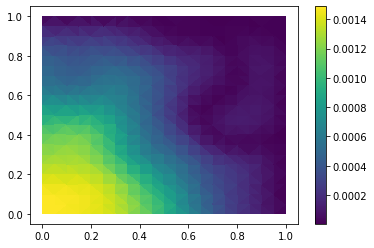

In [62]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              np.abs(em_u_samples[-1] - mcmc_cum_mean[-1]))
plt.colorbar()